In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geemap import ml
from sklearn import ensemble

import geemap, ee

import warnings
warnings.filterwarnings("ignore")

In [25]:
import sys  
sys.path.insert(0, '../lib/')
import sand_classification as sc
import quality_mosaic as qm

In [18]:
#open the excel file 'data/labels/gt-bands.xlsx' and combine all the sheets into one dataframe
df = pd.read_excel('../data/labels/gt-bands.xlsx', sheet_name=None)
df = pd.concat(df, ignore_index=True)
df

,Unnamed: 0,ID,Latitude,Longitude,Class,Date,Site,ATT ID,ImageName,Name,...,keep,location_tweaked,class_code,Country,Notes,Notes on how these were chosen,D50,D90,Distance Downstram of MFT (km),D84
0,0.0,sedinet-0,17.973859,-65.988747,sand,2020-06-18,Coastal,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,...,False,False,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,sedinet-1,18.459221,-65.987196,sand,2020-06-15,Coastal,2,ATT2_20200531_151022.jpg,PR002,...,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,sedinet-2,38.665018,-75.067643,sand,2020-06-22,Coastal,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,...,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,sedinet-3,38.665267,-75.067228,sand,2020-06-22,Coastal,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,...,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,sedinet-4,38.665184,-75.066829,sand,2020-06-22,Coastal,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,...,False,False,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,NaN,ns-17,21.969749,89.178629,water,2021-10-31,Sundarbans,NaN,NaN,NaN,...,True,False,4,Bangladesh,Water is sediment filled,NaN,NaN,NaN,NaN,NaN
130,NaN,ns-18,9.978316,76.252207,bare,2022-12-11,Cochin Docks,NaN,NaN,NaN,...,True,False,5,India,Kerala,NaN,NaN,NaN,NaN,NaN
131,NaN,ns-19,9.975609,76.255231,water,2022-12-11,Cochin Bay,NaN,NaN,NaN,...,True,False,4,India,Kerala,NaN,NaN,NaN,NaN,NaN
132,NaN,ns-20,41.019946,28.973160,bare,2021-12-11,Instanbul bridge,NaN,NaN,NaN,...,True,False,5,Turkey,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
display(df.columns)
keeper_columns = ['ID', 'class_code', 'B2_mean', 'B3_mean', 'B4_mean', 'B8_mean',
       'B8A_mean', 'B11_mean', 'B12_mean', 'VV_mean', 'VH_mean', 'mTGSI_mean',
       'BSI_mean', 'NDWI_mean', 'keep']

plotting_columns = ['ID', 'Class', 'Latitude','Longitude']


Index(['Unnamed: 0', 'ID', 'Latitude', 'Longitude', 'Class', 'Date', 'Site',
       'ATT ID', 'ImageName', 'Name', 'Coin', 'd10', 'd16', 'd25', 'd50',
       'd65', 'd75', 'd84', 'd90', 'mean', 'location', 'City', 'FM', 'r2_fm',
       'stderr_fm', 'FM_class', 'D75', 'D4_75', 'D_075', 'r2_grid',
       'stderr_grid', 'Source', 'B2_mean', 'B3_mean', 'B4_mean', 'B8_mean',
       'B8A_mean', 'B11_mean', 'B12_mean', 'VV_mean', 'VH_mean', 'mTGSI_mean',
       'BSI_mean', 'NDWI_mean', 'keep', 'location_tweaked', 'class_code',
       'Country', 'Notes', 'Notes on how these were chosen', 'D50', 'D90',
       'Distance Downstram of MFT (km)', 'D84'],
      dtype='object')

In [20]:
#set the type of 'keep' columns to boolean
df['keep'] = df['keep'].astype(bool)
#check if the column 'ID' is unique
df['ID'].is_unique

True

In [21]:
labels = df[keeper_columns]
labels = labels[labels['keep'] == True].reset_index(drop=True)

#check if there are any null values
labels.isnull().sum()

ID            0
class_code    0
B2_mean       0
B3_mean       0
B4_mean       0
B8_mean       0
B8A_mean      0
B11_mean      0
B12_mean      0
VV_mean       0
VH_mean       0
mTGSI_mean    0
BSI_mean      0
NDWI_mean     0
keep          0
dtype: int64

In [22]:
labels

,ID,class_code,B2_mean,B3_mean,B4_mean,B8_mean,B8A_mean,B11_mean,B12_mean,VV_mean,VH_mean,mTGSI_mean,BSI_mean,NDWI_mean,keep
0,sedinet-1,1,1909.959839,2408.223389,2711.885498,3095.604492,3023.788086,2754.255127,2127.833740,-12.245424,-19.858164,-0.011403,0.046433,-0.133137,True
1,sedinet-2,1,2296.496094,2880.759766,3350.108643,4453.658691,4434.116211,5267.705566,5056.720703,-15.439523,-21.776503,0.089654,0.120402,-0.217234,True
2,sedinet-3,1,2691.572021,3383.153076,4000.680176,4829.711914,4851.709473,6080.360352,6131.175781,-18.035833,-26.745705,0.124123,0.145531,-0.176357,True
3,sedinet-5,1,3196.637695,3728.590576,4162.385742,4965.102539,5022.440918,5703.236328,5773.673340,-17.205423,-24.548832,0.080977,0.094375,-0.141128,True
4,sedinet-6,1,3171.919922,3666.031982,4147.919922,4890.768066,4860.855957,5720.423828,5889.215820,-15.189863,-23.240173,0.090201,0.100478,-0.143360,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,ns-17,4,870.122803,1095.929810,1060.596436,970.807007,952.868408,289.307007,160.912277,-18.204535,-24.624493,-0.148715,-0.153062,0.065929,True
113,ns-18,5,1358.083008,1590.857178,1731.253418,1777.852539,1843.774170,1959.027710,1801.608276,-7.064449,-13.419824,0.048165,0.081212,-0.054851,True
114,ns-19,4,489.859375,571.312500,380.609375,138.546875,121.046875,60.656250,42.906250,-20.244843,-28.267944,-0.126171,-0.174898,0.609784,True
115,ns-20,5,745.926575,743.293762,780.807922,795.406799,751.265564,697.581909,659.079102,-2.869668,-12.569727,-0.025577,-0.018996,-0.032109,True


<AxesSubplot:xlabel='class_code', ylabel='count'>

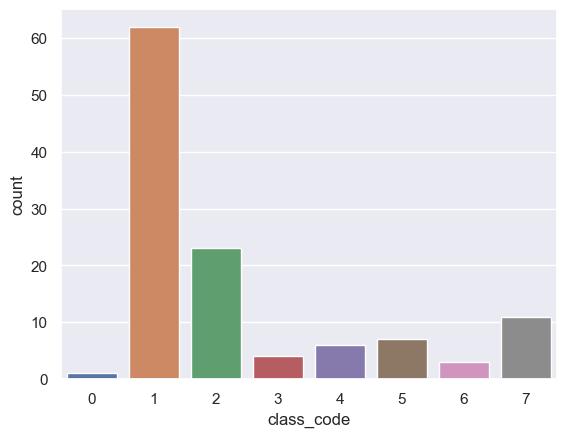

In [28]:
#Using seaborn plot the distribution of each class_code
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="class_code", data=labels)


# Train a model locally using scikit-learn

In [29]:
label = 'class_code'
features = qm.OBIA_BANDS

# get the features and labels into separate variables
X = labels[features]
y = labels[label]
display(X, y)

,B2_mean,B3_mean,B4_mean,B8_mean,B8A_mean,B11_mean,B12_mean,VV_mean,VH_mean,mTGSI_mean,BSI_mean,NDWI_mean
0,1909.959839,2408.223389,2711.885498,3095.604492,3023.788086,2754.255127,2127.833740,-12.245424,-19.858164,-0.011403,0.046433,-0.133137
1,2296.496094,2880.759766,3350.108643,4453.658691,4434.116211,5267.705566,5056.720703,-15.439523,-21.776503,0.089654,0.120402,-0.217234
2,2691.572021,3383.153076,4000.680176,4829.711914,4851.709473,6080.360352,6131.175781,-18.035833,-26.745705,0.124123,0.145531,-0.176357
3,3196.637695,3728.590576,4162.385742,4965.102539,5022.440918,5703.236328,5773.673340,-17.205423,-24.548832,0.080977,0.094375,-0.141128
4,3171.919922,3666.031982,4147.919922,4890.768066,4860.855957,5720.423828,5889.215820,-15.189863,-23.240173,0.090201,0.100478,-0.143360
...,...,...,...,...,...,...,...,...,...,...,...,...
112,870.122803,1095.929810,1060.596436,970.807007,952.868408,289.307007,160.912277,-18.204535,-24.624493,-0.148715,-0.153062,0.065929
113,1358.083008,1590.857178,1731.253418,1777.852539,1843.774170,1959.027710,1801.608276,-7.064449,-13.419824,0.048165,0.081212,-0.054851
114,489.859375,571.312500,380.609375,138.546875,121.046875,60.656250,42.906250,-20.244843,-28.267944,-0.126171,-0.174898,0.609784
115,745.926575,743.293762,780.807922,795.406799,751.265564,697.581909,659.079102,-2.869668,-12.569727,-0.025577,-0.018996,-0.032109


0      1
1      1
2      1
3      1
4      1
      ..
112    4
113    5
114    4
115    5
116    7
Name: class_code, Length: 117, dtype: int64

## Fit the classifier

In [31]:
n_trees = 50
rf = ensemble.RandomForestClassifier(n_trees).fit(X, y)

### Convert a sklearn classifier object to a list of strings

In [33]:
trees = ml.rf_to_strings(rf, features)
# print the first tree to see the result
# print(trees[0])
print(trees[1])


1) root 74 9999 9999 (8.570901717798108)
  2) VH_mean <= -21.410461 74 0.6734 1
    4) B12_mean <= 1477.829712 56 0.5214 1
      8) B11_mean <= 322.154739 10 0.6016 3
        16) B2_mean <= 4611.476929 6 0.0000 4 *
        17) B2_mean > 4611.476929 1 0.0000 7 *
      9) B11_mean > 322.154739 3 0.0000 3 *
    5) B12_mean > 1477.829712 56 0.5214 1
      10) NDWI_mean <= -0.068544 46 0.3100 1
        20) B8A_mean <= 5706.385010 38 0.1537 1
          40) B8A_mean <= 2929.918579 34 0.1014 1
            80) B8A_mean <= 2889.675659 14 0.2449 1
              160) mTGSI_mean <= 0.085734 13 0.0997 1
                320) B8_mean <= 2657.400024 4 0.0000 1 *
                321) B8_mean > 2657.400024 1 0.0000 2 *
              161) mTGSI_mean > 0.085734 8 0.0000 1 *
            81) B8A_mean > 2889.675659 1 0.0000 2 *
          41) B8A_mean > 2929.918579 20 0.0000 1 *
        21) B8A_mean > 5706.385010 38 0.1537 1
          42) VH_mean <= -25.790877 3 0.0000 1 *
          43) VH_mean > -25.790877 1 

In [35]:
# number of trees we converted should equal the number of trees we defined for the model
assert(len(trees) == n_trees)

### Convert sklearn classifier to GEE classifier

In [39]:
ee.Initialize()

In [63]:
# create a ee classifier to use with ee objects from the trees
RF = ml.strings_to_classifier(trees)
RF.getInfo()

{'type': 'Classifier.decisionTreeEnsemble',
 'treeStrings': ['1) root 78 9999 9999 (9.004036861975342)\n  2) VH_mean <= -21.410461 78 0.6431 1\n    4) B11_mean <= 917.105164 59 0.4833 1\n      8) B11_mean <= 322.154739 9 0.5800 4\n        16) B8A_mean <= 4121.641968 5 0.0000 4 *\n        17) B8A_mean > 4121.641968 1 0.0000 6 *\n      9) B11_mean > 322.154739 3 0.0000 3 *\n    5) B11_mean > 917.105164 59 0.4833 1\n      10) VV_mean <= -15.092529 50 0.3522 1\n        20) mTGSI_mean <= 0.105056 37 0.2037 1\n          40) B2_mean <= 4065.662842 28 0.1302 1\n            80) B4_mean <= 2761.672607 26 0.0918 1\n              160) B8_mean <= 3025.992432 14 0.1504 1\n                320) mTGSI_mean <= 0.071649 13 0.0799 1\n                  640) B12_mean <= 2436.612610 5 0.0000 1 *\n                  641) B12_mean > 2436.612610 1 0.0000 2 *\n                321) mTGSI_mean > 0.071649 7 0.0000 1 *\n              161) B8_mean > 3025.992432 1 0.0000 5 *\n            81) B4_mean > 2761.672607 12 0.

# Classify

In [114]:
# center for AOI
lon, lat = 84.2047028760486,24.90192702360151 #Dehri-on-Sone
lat, lon =  28.773532,  80.125429 #Sharda GST - DIngle 2016
lat, lon =  29.102294,  80.142014 #Shardo-0
roi_buffer_m = 5000

date = '2022-05-09'
max_search_window_months = 3
median_samples = 5
mosaic_method = 'median'

In [115]:
point = ee.Geometry.Point([lon, lat])
# sample = point.buffer(sampling_buffer_m).bounds()
roi = point.buffer(roi_buffer_m).bounds()


s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=False)
s1_s2.bandNames()

Search window from 2022-02-09 to 2022-08-09


In [116]:
Map = geemap.Map()
Map.centerObject(point, 12)
Map.add_basemap('SATELLITE')
Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI')
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')
Map

Map(center=[29.102294000000008, 80.142014], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

In [111]:
size_segmentation = 10

# Segmentation using a SNIC approach based on the dataset previosly generated
seeds = ee.Algorithms.Image.Segmentation.seedGrid(size_segmentation); #to get spaced grid notes at a distance specified by segmentation size parameter
snic = ee.Algorithms.Image.Segmentation.SNIC(
  image = s1_s2, #our multi-band image with selected bands same as for pixel-based
  compactness = 0,  #allow flexibility in object shape, no need to force compactness
  connectivity = 8, #use all 8 neighboring pixels in a pixel neighborhood
  neighborhoodSize = 256,
  seeds = seeds
)
vizParamsSNIC = {'bands': ['B4_mean','B3_mean','B11_mean'], 'min': 0, 'max': 3000}
Map.addLayer(snic, vizParamsSNIC,'SNIC', True)


#To visualize snic result:
Map.addLayer(snic.randomVisualizer(), None, 'Clusters', False)

#The next step generates a list of band names from the snic image, but without "clusters"
#since we don't need to use pixel values of their cluster IDs as a basis for class mapping:
predictionBands=snic.bandNames().remove("clusters")

In [112]:
classy_RF = snic.select(predictionBands).classify(RF)
#necessary to keep the final resolution at 10m: not needed if you're zooming around and using interactively
classy_RF = classy_RF.reproject (crs = classy_RF.projection (), scale = 10)


In [113]:
palette = ['008080','f3ff4a','ffa500','ff00ff', '2E86C1','8c411d','00854d','551a4d']

classy_visParams = {
    'min': 0,
    'max': 4000,
    'palette': palette,
}

Map.addLayer(
    classy_RF,
    {"min": 0, "max": len(qm.class_dict)-1, "palette": palette},
    'classification',
)

legend_dict = {
    'fine': '008080', 
    'sand': 'f3ff4a', 
    'gravel': 'ffa500',
    'whitewater':'ff00ff',
    'water': '2E86C1',
    'bare': '8c411d', 
    'greenveg': '00854d',
    'other': '551a4d'
}

Map.add_legend(legend_title="Classes", legend_dict=legend_dict)
